In [231]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pytz
import os

from scipy.stats import poisson
from scipy.optimize import minimize

from datetime import datetime, timedelta, timezone

from IPython.display import display, HTML

In [232]:
# Avoid line breaks by Jupyter (following https://stackoverflow.com/a/70433850/7395592)
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))
# Avoid premature line breaks by Numpy and show all array entries
np.set_printoptions(linewidth=np.inf, threshold=np.inf)
np.set_printoptions(suppress=True)

In [233]:
sim_date = datetime.fromisoformat("2024-06-14").replace(tzinfo=pytz.UTC)
sim_year_max = 2024
sim_year_min = 2012

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36"
}

uefa = {
    "competitionId": 3,
    "url_competition": "https://comp.uefa.com/v2/competition-structure",
    "url_matches": "https://match.uefa.com/v5/matches",
    "url_teams": "https://comp.uefa.com/v2/teams",
    "season_years": range(sim_year_max, sim_year_min-1, -4),
}


In [234]:
def get_all_teams_data(competitionId, phase, season_years, limit=100):

    data = pd.DataFrame()
    for seasonYear in season_years:

        params = {
            "competitionId": competitionId,
            "phase": phase,
            "seasonYear": seasonYear,
            "limit": limit,
        }

        data_season = pd.DataFrame()
        for offset in range(0, limit * 5, limit):

            params_iter = {"offset": offset}
            _params = params | params_iter
            response = requests.get(uefa["url_teams"], params=_params, headers=headers)

            data_iter = pd.DataFrame(response.json())
            if data_iter.empty:
                break

            data_season = pd.concat([data_season, data_iter], ignore_index=True)

        data_season["seasonYear"] = seasonYear
        data = pd.concat([data, data_season], ignore_index=True)

    return data[["id", "internationalName", "teamCode", "seasonYear"]]

In [235]:
def get_nested_value(d, keys, default=None):
    for key in keys:
        if isinstance(d, dict):
            d = d.get(key, default)
        else:
            return default
    return d

In [236]:
def get_all_match_data(competitionId, season_years, limit=100):

    data = []
    for seasonYear in season_years:

        params = {
            "competitionId": competitionId,
            "seasonYear": seasonYear,
            "limit": limit,
        }

        data_season = []
        for offset in range(0, limit * 5, limit):

            params_iter = {"offset": offset}
            _params = params | params_iter
            response = requests.get(uefa["url_matches"], params=_params, headers=headers)

            data_iter = response.json()
            if not data_iter:
                break

            data_season += data_iter

        data += data_season

    data_reduced = []
    for record in data:

        datetime_str = get_nested_value(record, ["kickOffTime", "dateTime"])
        datetime_offset_str = get_nested_value(record, ["kickOffTime", "utcOffsetInHours"])
        if datetime_str is None:
            is_completed = False
            parsed_date = None
        else:
            parsed_date = datetime.fromisoformat(datetime_str.replace("Z", "+00:00")) + timedelta(
                hours=datetime_offset_str
            )
            current_date = datetime.now(timezone.utc)
            is_completed = parsed_date < current_date

        home_score_total = get_nested_value(record, ["score", "total", "home"])
        away_score_total = get_nested_value(record, ["score", "total", "away"])

        home_team_code = get_nested_value(record, ["homeTeam", "teamCode"])
        away_team_code = get_nested_value(record, ["awayTeam", "teamCode"])

        score_summary = (
            None
            if home_score_total is None
            else " ".join(
                [
                    home_team_code,
                    str(home_score_total),
                    "-",
                    str(away_score_total),
                    away_team_code,
                ]
            )
        )

        result = (
            None
            if home_score_total is None
            else ("H" if home_score_total > away_score_total else "A" if home_score_total < away_score_total else "D")
        )

        status = get_nested_value(record, ["round", "status"])
        if status == "UPCOMING":
            continue

        record_reduced = {
            "id": record["id"],
            "season_year": record["seasonYear"],
            "date": parsed_date,
            # Context
            # "round": get_nested_value(record, ["round", "id"]),
            "phase": get_nested_value(record, ["round", "phase"]),
            "mode": get_nested_value(record, ["round", "mode"]),
            "status": status,
            "is_completed": is_completed,
            # Home Team
            "home_team": get_nested_value(record, ["homeTeam", "id"]),
            "home_team_name": get_nested_value(record, ["homeTeam", "internationalName"]),
            "home_team_code": home_team_code,
            "home_score": get_nested_value(record, ["score", "regular", "home"]),
            "home_score_total": home_score_total,
            # Away Team
            "away_team": get_nested_value(record, ["awayTeam", "id"]),
            "away_team_name": get_nested_value(record, ["awayTeam", "internationalName"]),
            "away_team_code": away_team_code,
            "away_score": get_nested_value(record, ["score", "regular", "away"]),
            "away_score_total": away_score_total,
            # Score/Result
            "score": score_summary,
            "result": result,
            # "temperature": get_nested_value(record, ["condition", "temperature"]),
            # "humidity": get_nested_value(record, ["condition", "humidity"]),
            # "windSpeed": get_nested_value(record, ["condition", "windSpeed"]),
            # "pitchCondition": get_nested_value(record, ["condition", "pitchCondition"]),
            # "weatherCondition": get_nested_value(record, ["condition", "weatherCondition"]),
        }
        data_reduced.append(record_reduced)
        # print({k: type(v) for k, v in record_reduced.items()})

    df = pd.DataFrame(data_reduced)

    return df

In [237]:
teams = get_all_teams_data(uefa["competitionId"], "ALL", uefa["season_years"])
teams_2024 = get_all_teams_data(uefa["competitionId"], "TOURNAMENT", [2024])

matches = get_all_match_data(uefa["competitionId"], uefa["season_years"])

In [238]:
matches_ = matches

matches_ = matches_.loc[matches_["is_completed"]]
# matches_ = matches_.loc[matches_["date"] < sim_date]
matches_ = matches_.loc[matches_["home_score_total"] >= 0]
matches_ = matches_.drop(["is_completed", "home_score", "away_score"], axis=1)
matches_ = matches_.rename(
    columns={
        "home_score_total": "HomeGoals",
        "away_score_total": "AwayGoals",
        "home_team_name": "HomeTeam",
        "away_team_name": "AwayTeam",
    }
)
matches_ = matches_[["id","HomeTeam","AwayTeam","HomeGoals","AwayGoals"]]
matches_.mean(numeric_only=True)

HomeGoals    1.562176
AwayGoals    1.231434
dtype: float64

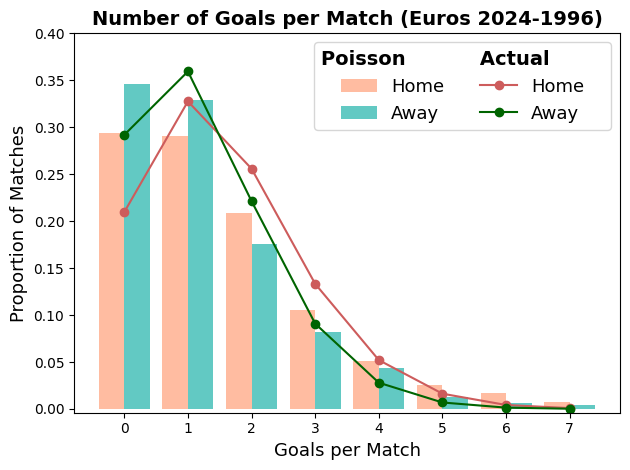

In [239]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack(
    [[poisson.pmf(i, matches_.mean(numeric_only=True).iloc[j]) for i in range(8)] for j in range(2)]
)

# plot histogram of actual goals
plt.hist(
    matches_[["HomeGoals", "AwayGoals"]].values,
    range(9),
    alpha=0.7,
    label=["Home", "Away"],
    density=True,
    color=["#FFA07A", "#20B2AA"],
)

# add lines for the Poisson distributions
(pois1,) = plt.plot(
    [i - 0.5 for i in range(1, 9)], poisson_pred[:, 0], linestyle="-", marker="o", label="Home", color="#CD5C5C"
)
(pois2,) = plt.plot(
    [i - 0.5 for i in range(1, 9)], poisson_pred[:, 1], linestyle="-", marker="o", label="Away", color="#006400"
)

leg = plt.legend(loc="upper right", fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop={"size": "14", "weight": "bold"})

plt.xticks([i - 0.5 for i in range(1, 9)], [i for i in range(8)])
plt.xlabel("Goals per Match", size=13)
plt.ylabel("Proportion of Matches", size=13)
plt.title("Number of Goals per Match (Euros 2024-1996)", size=14, fontweight="bold")
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()

In [240]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_model_data = pd.concat(
    [
        matches_[["HomeTeam", "AwayTeam", "HomeGoals"]]
        .assign(home=1)
        .rename(columns={"HomeTeam": "team", "AwayTeam": "opponent", "HomeGoals": "goals"}),
        matches_[["AwayTeam", "HomeTeam", "AwayGoals"]]
        .assign(home=0)
        .rename(columns={"AwayTeam": "team", "HomeTeam": "opponent", "AwayGoals": "goals"}),
    ]
)

poisson_model = smf.glm(
    formula="goals ~ home + team + opponent", data=goal_model_data, family=sm.families.Poisson()
).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 2316
Model:                            GLM   Df Residuals:                     2204
Model Family:                 Poisson   Df Model:                          111
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3049.1
Date:                Mon, 17 Jun 2024   Deviance:                       2170.2
Time:                        17:01:09   Pearson chi2:                 1.96e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4797
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -0.2197      0.218     -1.009      0.313      -0.646       0.207
team[T.Andorra]                       -1.4148      0.337     -4.197      0.000      -2.076      -0.754
team[T.Armenia]                        0.1960      0.207      0.945      0.345      -0.210       0.602
team[T.Austria]                        0.3819      0.189      2.018      0.044       0.011       0.753
team[T.Azerbaijan]                    -0.2156      0.242     -0.892      0.373      -0.690       0.258
team[T.Belarus]                       -0.4711      0.239     -1.967      0.049      -0.940      -0.002
team[T.Belgium]                        0.6719      0.177      3.796      0.000       0.325       1.019
team[T.Bosnia and Herzegovina]         0.1857      0.193      0.961      0.336      -0.193       0.564
team[T.Bulgaria]                      -0.4327      0.251     -1.727      0.084      -0.924       0.058
team[T.Croatia]                        0.4310      0.187      2.302      0.021       0.064       0.798
team[T.Cyprus]                        -0.0681      0.218     -0.312      0.755      -0.496       0.360
team[T.Czechia]                        0.2270      0.192      1.180      0.238      -0.150       0.604
team[T.Denmark]                        0.3547      0.187      1.901      0.057      -0.011       0.720
team[T.England]                        0.7393      0.177      4.180      0.000       0.393       1.086
team[T.Estonia]                       -0.6299      0.252     -2.504      0.012      -1.123      -0.137
team[T.FYR Macedonia]                 -0.5145      0.308     -1.670      0.095      -1.118       0.089
team[T.Faroe Islands]                 -0.8223      0.280     -2.934      0.003      -1.372      -0.273
team[T.Finland]                       -0.0190      0.198     -0.096      0.924      -0.408       0.370
team[T.France]                         0.5770      0.183      3.161      0.002       0.219       0.935
team[T.Georgia]                       -0.3804      0.222     -1.712      0.087      -0.816       0.055
team[T.Germany]                        0.8329      0.178      4.666      0.000       0.483       1.183
team[T.Gibraltar]                     -1.5878      0.474     -3.348      0.001      -2.517      -0.658
team[T.Greece]                        -0.0382      0.201     -0.190      0.849      -0.432       0.356
team[T.Hungary]                        0.2130      0.190      1.122      0.262      -0.159       0.585
team[T.Iceland]                        0.2367      0.191      1.238      0.216      -0.138       0.611
team[T.Israel]                         0.0400      0.201      0.199      0.843      -0.355       0.435
team[T.Italy]                          0.5692      0.178      3.203      0.001       0.221      

In [241]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(
        pd.DataFrame(data={"team": homeTeam, "opponent": awayTeam, "home": 1}, index=[1])
    ).values[0]
    away_goals_avg = foot_model.predict(
        pd.DataFrame(data={"team": awayTeam, "opponent": homeTeam, "home": 0}, index=[1])
    ).values[0]
    team_pred = [
        [poisson.pmf(i, team_avg) for i in range(0, max_goals + 1)] for team_avg in [home_goals_avg, away_goals_avg]
    ]
    return np.outer(np.array(team_pred[0]), np.array(team_pred[1]))


ser_eng = simulate_match(poisson_model, "Serbia", "England", max_goals=5)
with np.printoptions(precision=3, suppress=True):
    print(ser_eng)


predicted_score = np.unravel_index(np.argmax(ser_eng), ser_eng.shape)
print(predicted_score)

[[0.04  0.101 0.128 0.108 0.069 0.035]
 [0.027 0.069 0.088 0.075 0.047 0.024]
 [0.009 0.024 0.03  0.026 0.016 0.008]
 [0.002 0.005 0.007 0.006 0.004 0.002]
 [0.    0.001 0.001 0.001 0.001 0.   ]
 [0.    0.    0.    0.    0.    0.   ]]
(0, 2)


In [242]:
def solve_parameters(dataset, debug=False, init_vals=None, options={'disp': True, 'maxiter': 100},
                     constraints=[{'type': 'eq', 'fun': lambda x: sum(x[:20]) - 20}], **kwargs):
    teams = np.sort(dataset['HomeTeam'].unique())

    # Ensure home and away teams are the same
    if not np.array_equal(teams, np.sort(dataset['AwayTeam'].unique())):
        raise ValueError("Mismatch between home and away teams.")
    
    n_teams = len(teams)
    
    # Initialize model parameters if not provided
    if init_vals is None:
        init_vals = np.concatenate([
            np.random.uniform(0, 1, n_teams),    # attack strength
            np.random.uniform(0, -1, n_teams),   # defence strength
            np.array([0, 1.0])                   # rho (score correction), gamma (home advantage)
        ])
    
    def dc_log_like(x, y, lambda_x, mu_y, rho):
        return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
                np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

    def estimate_parameters(params):
        attack_strengths = params[:n_teams]
        defence_strengths = params[n_teams:2*n_teams]
        rho, gamma = params[-2:]
        
        home_attack = dataset['HomeTeam'].map(dict(zip(teams, attack_strengths)))
        home_defence = dataset['HomeTeam'].map(dict(zip(teams, defence_strengths)))
        away_attack = dataset['AwayTeam'].map(dict(zip(teams, attack_strengths)))
        away_defence = dataset['AwayTeam'].map(dict(zip(teams, defence_strengths)))
        
        lambda_x = np.exp(home_attack + away_defence + gamma)
        mu_y = np.exp(away_attack + home_defence)
        
        # Handle cases where lambda_x or mu_y are zero or negative
        lambda_x = np.where(lambda_x <= 0, 1e-10, lambda_x)
        mu_y = np.where(mu_y <= 0, 1e-10, mu_y)
        
        log_likelihood = (
            np.log(rho_correction(dataset['HomeGoals'], dataset['AwayGoals'], lambda_x, mu_y, rho)) +
            np.log(poisson.pmf(dataset['HomeGoals'], lambda_x)) +
            np.log(poisson.pmf(dataset['AwayGoals'], mu_y))
        )
        
        return -np.sum(log_likelihood)  # Negative sum of log-likelihood to minimize
        
    opt_output = minimize(estimate_parameters, init_vals, options=options, constraints=constraints, **kwargs)

    if debug:
        return opt_output
    else:
        result_keys = (["attack_" + team for team in teams] + 
                       ["defence_" + team for team in teams] + 
                       ['rho', 'home_adv'])
        return dict(zip(result_keys, opt_output.x))

def rho_correction(x, y, lambda_x, mu_y, rho):
    # Vectorized implementation of rho_correction function
    condition1 = (x == 0) & (y == 0)
    condition2 = (x == 0) & (y == 1)
    condition3 = (x == 1) & (y == 0)
    condition4 = (x == 1) & (y == 1)
    
    result = np.where(condition1, 1 - (lambda_x * mu_y * rho),
             np.where(condition2, 1 + (lambda_x * rho),
             np.where(condition3, 1 + (mu_y * rho),
             np.where(condition4, 1 - rho,
                      1.0))))
    
    return result

In [243]:
params2 = solve_parameters(matches_)

C:\Users\samue\AppData\Local\Temp\ipykernel_14932\1602772899.py:41: RuntimeWarning: invalid value encountered in log
  np.log(rho_correction(dataset['HomeGoals'], dataset['AwayGoals'], lambda_x, mu_y, rho)) +
C:\Users\samue\AppData\Local\Temp\ipykernel_14932\1602772899.py:43: RuntimeWarning: divide by zero encountered in log
  np.log(poisson.pmf(dataset['AwayGoals'], mu_y))
C:\Users\samue\AppData\Local\Temp\ipykernel_14932\1602772899.py:41: RuntimeWarning: invalid value encountered in log
  np.log(rho_correction(dataset['HomeGoals'], dataset['AwayGoals'], lambda_x, mu_y, rho)) +
C:\Users\samue\AppData\Local\Temp\ipykernel_14932\1602772899.py:42: RuntimeWarning: divide by zero encountered in log
  np.log(poisson.pmf(dataset['HomeGoals'], lambda_x)) +
C:\Users\samue\AppData\Local\Temp\ipykernel_14932\1602772899.py:43: RuntimeWarning: divide by zero encountered in log
  np.log(poisson.pmf(dataset['AwayGoals'], mu_y))
C:\Users\samue\AppData\Local\Temp\ipykernel_14932\1602772899.py:41: Runt

Iteration limit reached    (Exit mode 9)
            Current function value: 3048.8106159405434
            Iterations: 100
            Function evaluations: 11674
            Gradient evaluations: 100


In [244]:
# params2["rho"] = -0.12851515187235166
params2

{'attack_Albania': 1.0576677223310325,
 'attack_Andorra': -0.3592073387425114,
 'attack_Armenia': 1.2556819415452796,
 'attack_Austria': 1.4430717026241389,
 'attack_Azerbaijan': 0.8439358624604086,
 'attack_Belarus': 0.5880037481865108,
 'attack_Belgium': 1.730995584415284,
 'attack_Bosnia and Herzegovina': 1.246673638985062,
 'attack_Bulgaria': 0.6248137561224538,
 'attack_Croatia': 1.4899738023170763,
 'attack_Cyprus': 0.9912941794114332,
 'attack_Czechia': 1.2843810483792226,
 'attack_Denmark': 1.4151061432302474,
 'attack_England': 1.8009998189139567,
 'attack_Estonia': 0.42776413914750977,
 'attack_FYR Macedonia': 0.5381465001246422,
 'attack_Faroe Islands': 0.23367765773567464,
 'attack_Finland': 1.0390291540903458,
 'attack_France': 1.6365263179529654,
 'attack_Georgia': 0.6775316319902335,
 'attack_Germany': 1.8925583559452208,
 'attack_Gibraltar': -0.5287419503774686,
 'attack_Greece': 1.0198083656941452,
 'attack_Hungary': 1.2762153473657722,
 'attack_Iceland': 1.29698900298

In [245]:
def calc_means(param_dict, homeTeam, awayTeam):
    return [np.exp(param_dict['attack_'+homeTeam] + param_dict['defence_'+awayTeam] + param_dict['home_adv']),
            np.exp(param_dict['defence_'+homeTeam] + param_dict['attack_'+awayTeam])]

def dixon_coles_simulate_match(params_dict, homeTeam, awayTeam, max_goals=10):
    team_avgs = calc_means(params_dict, homeTeam, awayTeam)
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in team_avgs]
    output_matrix = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    correction_matrix = np.array([[rho_correction(home_goals, away_goals, team_avgs[0],
                                                   team_avgs[1], params_dict['rho']) for away_goals in range(2)]
                                   for home_goals in range(2)])
    output_matrix[:2,:2] = output_matrix[:2,:2] * correction_matrix
    return output_matrix

In [246]:
ser_eng_dc = dixon_coles_simulate_match(params2, 'Serbia', 'England', max_goals=10)

with np.printoptions(precision=3, suppress=True):
    print(ser_eng_dc)

predicted_score = np.unravel_index(np.argmax(ser_eng_dc), ser_eng_dc.shape)
print(predicted_score)

[[0.042 0.098 0.128 0.108 0.069 0.035 0.015 0.005 0.002 0.    0.   ]
 [0.025 0.072 0.088 0.075 0.047 0.024 0.01  0.004 0.001 0.    0.   ]
 [0.009 0.024 0.03  0.026 0.016 0.008 0.004 0.001 0.    0.    0.   ]
 [0.002 0.005 0.007 0.006 0.004 0.002 0.001 0.    0.    0.    0.   ]
 [0.    0.001 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]
(0, 2)


In [247]:
future_matches_ = matches

future_matches_ = future_matches_.loc[future_matches_["date"] >= sim_date]
future_matches_ = future_matches_.rename(
    columns={
        "home_score_total": "HomeGoals",
        "away_score_total": "AwayGoals",
        "home_team_name": "HomeTeam",
        "away_team_name": "AwayTeam",
    }
)
future_matches_["HomeGoalsActual"] = future_matches_["HomeGoals"]
future_matches_["AwayGoalsActual"] = future_matches_["AwayGoals"]

future_matches_ = future_matches_[["id","date","HomeTeam","AwayTeam","HomeGoals","AwayGoals","HomeGoalsActual","AwayGoalsActual"]]


for index, row in future_matches_.iterrows():
    prediction = dixon_coles_simulate_match(params2, row["HomeTeam"], row["AwayTeam"], max_goals=10)
    predicted_score = np.unravel_index(np.argmax(prediction), prediction.shape)

    future_matches_.loc[index, 'HomeGoals'] = predicted_score[0]
    future_matches_.loc[index, 'AwayGoals'] = predicted_score[1]

    result = (
        ("H" if predicted_score[0] > predicted_score[1] else "A" if predicted_score[0] < predicted_score[1] else "D")
    )

    result_actual = (
        "" if pd.isnull(row["HomeGoalsActual"])
        else ("H" if row["HomeGoalsActual"] > row["AwayGoalsActual"] else "A" if row["HomeGoalsActual"] < row["AwayGoalsActual"] else "D")
    )

    future_matches_.loc[index, 'Result'] = result
    future_matches_.loc[index, 'ResultActual'] = result_actual

    performance = 0
    if not pd.isnull(row["HomeGoalsActual"]):
        if predicted_score[0] == row["HomeGoalsActual"] and predicted_score[1] == row["AwayGoalsActual"]:
            performance += 5
        elif result == result_actual:
            performance += 2

    future_matches_.loc[index, 'ModelPerformance'] = performance

future_matches_ = future_matches_[["id","date","HomeTeam","AwayTeam","HomeGoals","AwayGoals","Result","HomeGoalsActual","AwayGoalsActual","ResultActual","ModelPerformance"]]

In [248]:
order_list = [
    "2036161",
    "2036162",
    "2036163",
    "2036164",
    "2036167",
    "2036165",
    "2036166",
    "2036170",
    "2036169",
    "2036168",
    "2036171",
    "2036172",
    "2036176",
    "2036173",
    "2036174",
    "2036177",
    "2036178",
    "2036175",
    "2036182",
    "2036179",
    "2036180",
    "2036184",
    "2036183",
    "2036181",
    "2036185",
    "2036186",
    "2036187",
    "2036188",
    "2036191",
    "2036192",
    "2036190",
    "2036189",
    "2036194",
    "2036193",
    "2036196",
    "2036195",
]

future_matches_["id"] = pd.Categorical(future_matches_["id"], categories=order_list, ordered=True)
future_matches_ = future_matches_.sort_values("id")

In [249]:
future_matches_.to_csv("predictions\euros2024_predictions_model"+str(sim_year_max)+"-"+str(sim_year_min)+".csv", index=False, encoding='utf-8-sig', mode='w')

In [250]:

# Function to load and sum a column from a CSV file
def sum_column_in_csv(file_path, column_name):
    try:
        df = pd.read_csv(file_path)
        summed_value = df[column_name].sum()
        return summed_value
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Specify the folder path containing CSV files
folder_path = 'predictions'  # Replace with your folder path

# Initialize a dictionary to store file names and summed values
file_summaries = {}

# Iterate over files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        summed_value = sum_column_in_csv(file_path, 'ModelPerformance')  # Replace 'ColumnName' with your column name
        
        if summed_value is not None:
            file_summaries[file_name] = summed_value

# Print file summaries
for file_name, summed_value in file_summaries.items():
    print(f"File: {file_name}, Performance: {summed_value}")


File: euros2024_predictions_model2024-1996.csv, Performance: 15.0
File: euros2024_predictions_model2024-2000.csv, Performance: 15.0
File: euros2024_predictions_model2024-2004.csv, Performance: 15.0
File: euros2024_predictions_model2024-2012.csv, Performance: 13.0
